In [1]:
import os
import time

import torch
import torchvision
import torchvision.transforms as transforms
import ssl
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm.notebook import tqdm
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from pytorch_dataset import HatsDataset
import torch.optim as optim
from tqdm.notebook import tqdm


In [2]:
in_channel = 3
num_class = 15
learning_rate = 1e-3
batch_size = 16
num_epochs = 20
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.RandomCrop(256, padding=3, padding_mode='constant'),
     transforms.RandomHorizontalFlip(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

subject = 'Data_Full'

dataset = HatsDataset(csv_file='FinalData/' + subject + '.csv',
                      root_dir='FinalData/' + subject,
                      transform=transform)  #8778

print(len(dataset))

# transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
divider = round(len(dataset) * 0.8)

trainset, testset = torch.utils.data.random_split(dataset, [divider, len(dataset) - divider])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('baseballcap', 'BikeHelmet', 'BucketHat', 'CowboyHat',
           'FeltHat', 'FireFighterHat', 'FlatCap', 'GraduationCap', 'Heaterhat', 'MilitaryHelmet',
           'MotorCycle Helmet', 'Police Hat', 'SateftyHelmet', 'TopHat', 'beanie')

8778


In [3]:
refresh_rate = round(divider / batch_size /3)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


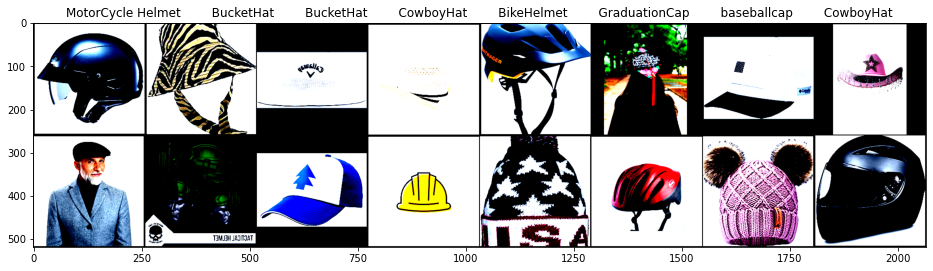

In [4]:
def imshow(img):
    # img = img / 2 + 0.4     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(16, 7))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title('        '.join('%5s' % classes[labels[j]] for j in range(8)))
    plt.show()


dataiter = iter(trainloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))

In [5]:
class Block(nn.Module):
    def __init__(
            self, in_channels, intermediate_channels, identity_downsample=None, stride=1
    ):
        super(Block, self).__init__()
        self.expansion = 4
        self.conv1 = nn.Conv2d(
            in_channels, intermediate_channels, kernel_size=1, stride=1, padding=0, bias=False
        )
        self.bn1 = nn.BatchNorm2d(intermediate_channels)
        self.conv2 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False
        )
        self.bn2 = nn.BatchNorm2d(intermediate_channels)
        self.conv3 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels * self.expansion,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False
        )
        self.bn3 = nn.BatchNorm2d(intermediate_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        self.stride = stride

    def forward(self, x):
        identity = x.clone()

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x

In [6]:
class ResNet(nn.Module):
    def __init__(self, block, layers):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(in_channel, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(
            block, layers[0], intermediate_channels=64, stride=1
        )
        self.layer2 = self._make_layer(
            block, layers[1], intermediate_channels=128, stride=2
        )
        self.layer3 = self._make_layer(
            block, layers[2], intermediate_channels=256, stride=2
        )
        self.layer4 = self._make_layer(
            block, layers[3], intermediate_channels=512, stride=2
        )

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_class)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.max_pool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avg_pool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_down_sample = None
        layers = []

        if stride != 1 or self.in_channels != intermediate_channels * 4:
            identity_down_sample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    intermediate_channels * 4,
                    kernel_size=1,
                    stride=stride,
                    bias=False
                ),
                nn.BatchNorm2d(intermediate_channels * 4),
            )

        layers.append(
            block(self.in_channels, intermediate_channels, identity_down_sample, stride)
        )

        # The expansion size is always 4 for ResNet 50,101,152
        self.in_channels = intermediate_channels * 4

        # first resnet layer: 256 will be mapped to 64 as intermediate layer,
        # then finally back to 256. no NEED identity down sample SO stride = 1,
        # and also same channels #.
        for j in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))

        return nn.Sequential(*layers)


def resnet50():
    return ResNet(Block, [3, 4, 6, 3])


def resnet101():
    return ResNet(Block, [3, 4, 23, 3])


def resnet152():
    return ResNet(Block, [3, 8, 36, 3])

In [7]:
def conv2d_Moduel(in_channel, out, K_sz=3, pad=1, st=1):
    hidden_layer = [nn.Conv2d(in_channel, out, kernel_size=K_sz, padding=pad, stride=st),
                    nn.BatchNorm2d(out),
                    nn.LeakyReLU(inplace=True)]
    return nn.Sequential(*hidden_layer)


class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, connect=True):
        super(ResNetBlock, self).__init__()
        self.connect = connect
        self.conv1 = nn.Sequential(conv2d_Moduel(in_channels, out_channels),
                                   nn.MaxPool2d(kernel_size=2, stride=2),  #downsize
                                   conv2d_Moduel(out_channels, out_channels))
        self.conv2 = nn.Sequential(conv2d_Moduel(out_channels, out_channels),
                                   conv2d_Moduel(out_channels, out_channels))
        self.relu = nn.LeakyReLU(inplace=True)

    def forward(self, x):
        if self.connect:
            y = self.conv1(x)
        else:
            y = self.conv2(x)
            y = y + x
        z = self.conv2(y)
        z = z + y
        z = self.relu(z)
        return z


class ResNet18(nn.Module):
    def __init__(self):
        super(ResNet18, self).__init__()
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
        self.conv1 = conv2d_Moduel(3, 64, K_sz=7, pad=3, st=2)
        self.conv2 = ResNetBlock(64, 64, connect=False)
        self.conv3 = ResNetBlock(64, 128)
        self.conv4 = ResNetBlock(128, 256)
        self.conv5 = ResNetBlock(256, 512)
        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                        nn.Flatten(),
                                        nn.Linear(512 * 4 * 4, 256),
                                        nn.LeakyReLU(),
                                        nn.Linear(256, 128),
                                        nn.LeakyReLU(),
                                        nn.Linear(128, 15)
                                        )

    def forward(self, x):
        x = self.conv1(x)  #layer 1
        x = self.conv2(x)  #layer 2,3,4,5
        x = self.conv3(x)  #layer 6,7,8,9
        x = self.conv4(x)  #layer 10,11,12,13
        x = self.conv5(x)  #layer 14,15,16,17
        x = self.classifier(x)  #(18)
        return x
        #y = self.fc4(x)
        # YOUR CODE HERE
        #raise NotImplementedError()

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(244 * 244, 1200)
        self.fc2 = nn.Linear(1200, 84)
        self.fc3 = nn.Linear(84, 15)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

net = resnet50()
net.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (max_pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Block(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identity_downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
   

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
losses = []

In [14]:
reload = True
if reload:
    path = 'Checkpoints/Res50 16B 20eP Dataset_Full.pt'
    checkpoint = torch.load(path)

    net.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    ep = checkpoint['epoch']
    losses = checkpoint['losses']

    # trainset = checkpoint['trainset']
    # testset = checkpoint['testset']
    trainloader = checkpoint['trainloader']
    testloader = checkpoint['testloader']

  0%|          | 0/10 [00:00<?, ?it/s]

[ 1,  146]loss:0.108 || [ 1,  292]loss:0.111 || [ 1,  438]loss:0.132 || Lasted 2m 48s, Remaining 25.1m
[ 2,  146]loss:0.111 || [ 2,  292]loss:0.113 || [ 2,  438]loss:0.097 || Lasted 2m 47s, Remaining 22.3m
[ 3,  146]loss:0.097 || [ 3,  292]loss:0.102 || [ 3,  438]loss:0.113 || Lasted 2m 47s, Remaining 19.5m
[ 4,  146]loss:0.096 || [ 4,  292]loss:0.088 || [ 4,  438]loss:0.120 || Lasted 2m 48s, Remaining 16.8m
[ 5,  146]loss:0.094 || [ 5,  292]loss:0.090 || [ 5,  438]loss:0.143 || Lasted 2m 48s, Remaining 14.0m
[ 6,  146]loss:0.136 || [ 6,  292]loss:0.141 || [ 6,  438]loss:0.156 || Lasted 2m 48s, Remaining 11.2m
[ 7,  146]loss:0.150 || [ 7,  292]loss:0.140 || [ 7,  438]loss:0.121 || Lasted 2m 48s, Remaining 8.4m
[ 8,  146]loss:0.088 || [ 8,  292]loss:0.099 || [ 8,  438]loss:0.103 || Lasted 2m 47s, Remaining 5.6m
[ 9,  146]loss:0.101 || [ 9,  292]loss:0.112 || [ 9,  438]loss:0.084 || Lasted 2m 47s, Remaining 2.8m
[10,  146]loss:0.055 || [10,  292]loss:0.068 || [10,  438]loss:0.088 || Last

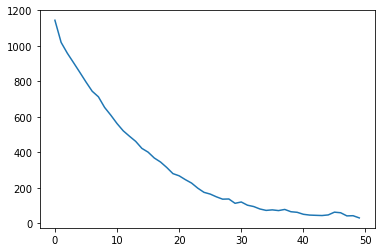

In [23]:
for epoch in tqdm(range(num_epochs)):  # loop over the dataset multiple times

    since = time.time()
    running_loss = 0.0
    loss_sum = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        # forward + backward + optimize
        # with torch.cuda.amp.autocast():
        outputs = net(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if i % refresh_rate == refresh_rate - 1:  # print every 2000 mini-batches
            print(f'[{epoch + 1:2d}, {i + 1:4d}]loss:{running_loss / refresh_rate:.3f}', end=" || ")
            loss_sum += running_loss
            running_loss = 0.0
    time_elapsed = time.time() - since
    print('Lasted {:.0f}m {:.0f}s, Remaining {:.1f}m'.format(time_elapsed // 60, time_elapsed % 60,
                                                             time_elapsed / 60 * (num_epochs - epoch - 1)))
    losses.append(loss_sum)

print('Finished Training')
plt.plot(losses)

In [24]:
correct = 0
total = 0

# YOUR CODE HERE
# raise NotImplementedError()
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)

        # images = images.cuda()
        # labels = labels.cuda()
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'{batch_size} batches, {num_epochs} Epochs')
print(f'Accuracy of the network on the validation images: {100 * correct // total} %')

16 batches, 10 Epochs
Accuracy of the network on the validation images: 72 %


In [25]:
# torch.cuda.is_available
# torch.save(net.state_dict(), PATH)
# epoch = 40
torch.save({
    'epoch': len(losses),
    'model_state_dict': net.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'losses': losses,
    'trainset': trainset,
    'testset': testset,
    'trainloader': trainloader,
    'testloader': testloader
}, 'Checkpoints/Res50 ' + str(batch_size) + 'B ' + str(len(losses)) + 'eP ' + subject + '.pt')
